In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import random
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Sequential
from tensorflow.keras.applications import EfficientNetB5
from sklearn.metrics import confusion_matrix
random.seed(123456)

In [3]:
img_path = []
thumb_path = []

for dirname, _, filenames in os.walk('/kaggle/input/UBC-OCEAN/train_thumbnails'):
    for filename in filenames:
        thumb_path.append(os.path.join(os.path.basename(dirname),os.path.basename(filename)))

In [4]:
thumb_path[:10]

['train_thumbnails/52275_thumbnail.png',
 'train_thumbnails/47960_thumbnail.png',
 'train_thumbnails/4_thumbnail.png',
 'train_thumbnails/57468_thumbnail.png',
 'train_thumbnails/20316_thumbnail.png',
 'train_thumbnails/27315_thumbnail.png',
 'train_thumbnails/46793_thumbnail.png',
 'train_thumbnails/43815_thumbnail.png',
 'train_thumbnails/25792_thumbnail.png',
 'train_thumbnails/48502_thumbnail.png']

We need to extract the id from every image name.

In [5]:
def extract_id(txt):
    figure = ["0","1","2","3","4","5","6","7","8","9"]
    img_id = ""
    for t in txt:
        if t in figure:
            img_id += t
    return int(img_id)

print(thumb_path[0])
print(extract_id(thumb_path[0]))

train_thumbnails/52275_thumbnail.png
52275


In [6]:
df_train_thumb = pd.DataFrame({"img_path":thumb_path})
df_train_thumb["image_id"] = df_train_thumb["img_path"].apply(extract_id)
df_train_thumb.head()

,img_path,image_id
0,train_thumbnails/52275_thumbnail.png,52275
1,train_thumbnails/47960_thumbnail.png,47960
2,train_thumbnails/4_thumbnail.png,4
3,train_thumbnails/57468_thumbnail.png,57468
4,train_thumbnails/20316_thumbnail.png,20316


In [7]:
df_train_thumb.shape

(513, 2)

Now we read the trainig dataframe

In [8]:
df_train = pd.read_csv("/kaggle/input/UBC-OCEAN/train.csv")
df_train.head()

,image_id,label,image_width,image_height,is_tma
0,4,HGSC,23785,20008,False
1,66,LGSC,48871,48195,False
2,91,HGSC,3388,3388,True
3,281,LGSC,42309,15545,False
4,286,EC,37204,30020,False


In [9]:
df_train.shape

(538, 5)

There's a mismatch in the shapes, we need to add the missing images from the train_images directory instead of train_thumbnails.

In [10]:
#generating a boolean array to find which values are missing
missing = ~df_train["image_id"].isin(df_train_thumb["image_id"])

#finding the indexes of values that are in the smaller dataset but not in the bigger one
missing_i = np.where( missing == True)[0]

#creating an array with the missing images id
missing_img_id = df_train["image_id"][missing_i]

len(missing_img_id)

25

In [11]:
missing_path = []
dirname = "train_images"
for i in missing_img_id:
    missing_path.append("{}/{}.png".format(dirname,i))

We check if the images fit the maximum size supported.

In [12]:
missing_img = []
directory = "/kaggle/input/UBC-OCEAN/"
max_size = 178956970

for path in missing_path:
    whole_path = directory + path
    img = cv2.imread(whole_path)
    if img.size >= max_size:
        print(path)

All the images fit the max size.

In [13]:
df_train_img = pd.DataFrame({"img_path":missing_path})
df_train_img["image_id"]=df_train_img["img_path"].apply(extract_id)
df_train_img.head()

,img_path,image_id
0,train_images/91.png,91
1,train_images/4134.png,4134
2,train_images/8280.png,8280
3,train_images/9200.png,9200
4,train_images/13568.png,13568


We concatenate the dataframes, sort the values and reset the indexes.

In [14]:
df_to_add = pd.concat([df_train_img,df_train_thumb],axis=0)
df_to_add.sort_values(by="image_id",inplace=True)
df_to_add.reset_index(drop=True, inplace=True)
df_to_add.head()

,img_path,image_id
0,train_thumbnails/4_thumbnail.png,4
1,train_thumbnails/66_thumbnail.png,66
2,train_images/91.png,91
3,train_thumbnails/281_thumbnail.png,281
4,train_thumbnails/286_thumbnail.png,286


We add the path of the images to the training dataframe

In [15]:
df_train["image_path"] = df_to_add["img_path"]
df_train.head()

,image_id,label,image_width,image_height,is_tma,image_path
0,4,HGSC,23785,20008,False,train_thumbnails/4_thumbnail.png
1,66,LGSC,48871,48195,False,train_thumbnails/66_thumbnail.png
2,91,HGSC,3388,3388,True,train_images/91.png
3,281,LGSC,42309,15545,False,train_thumbnails/281_thumbnail.png
4,286,EC,37204,30020,False,train_thumbnails/286_thumbnail.png


We visualise the data distribution

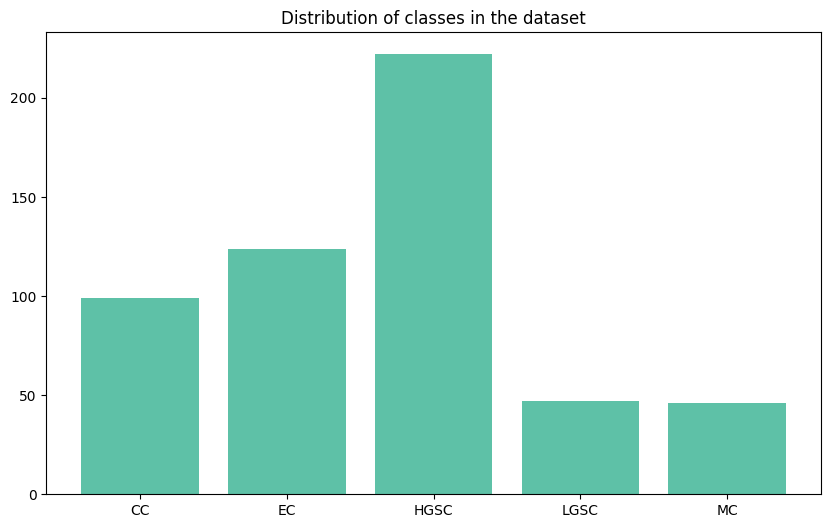

In [16]:
classes, counts = np.unique(df_train["label"],return_counts=True)

plt.figure(figsize=(10,6))
plt.bar(classes,counts,color="#5EC1A7")
plt.title("Distribution of classes in the dataset")
plt.show()

We check the relationship between label and is_tma.

In [17]:
df_grouped =df_train.groupby(by="label")
groups = list(df_grouped.groups.keys())
for g in groups:
    group = df_grouped.get_group(g)["is_tma"]
    x,y = np.unique(group,return_counts=True)[1]
    print("Percentage of microarrays in type {} : {} %".format(g,round(y/len(group)*100,2)))

Percentage of microarrays in type CC : 5.05 %
Percentage of microarrays in type EC : 4.03 %
Percentage of microarrays in type HGSC : 2.25 %
Percentage of microarrays in type LGSC : 10.64 %
Percentage of microarrays in type MC : 10.87 %


We generate images from the dataframe

In [18]:
df_train.drop(["image_id","image_width","is_tma","image_height"],axis=1,inplace=True)
df_train.head()

,label,image_path
0,HGSC,train_thumbnails/4_thumbnail.png
1,LGSC,train_thumbnails/66_thumbnail.png
2,HGSC,train_images/91.png
3,LGSC,train_thumbnails/281_thumbnail.png
4,EC,train_thumbnails/286_thumbnail.png


In [19]:
batch_size = 16
img_size = (300,300)

datagen = ImageDataGenerator(horizontal_flip=True,
                            vertical_flip=True,
                            rotation_range=180,
                            validation_split=0.2)

train_gen = datagen.flow_from_dataframe(
                directory=directory,
                dataframe=df_train,
                batch_size=batch_size,
                target_size=img_size,
                interpolation='bicubic',
                x_col="image_path",
                y_col="label",
                class_mode="categorical",
                subset="training")

val_gen = datagen.flow_from_dataframe(
                directory=directory,
                dataframe=df_train,
                batch_size=batch_size,
                target_size=img_size,
                x_col="image_path",
                y_col="label",
                class_mode="categorical",
                subset="validation")

Found 431 validated image filenames belonging to 5 classes.
Found 107 validated image filenames belonging to 5 classes.


We display some images.

In [20]:
num_batches = 5

images = []
labels = []

for i in range(num_batches):
    batch_data, batch_labels = train_gen.next()
    batch_data /= 255
    images.append(batch_data)

    labels.extend(np.argmax(batch_labels, axis=1))

images = np.concatenate(images, axis=0)

labels = np.array(labels)

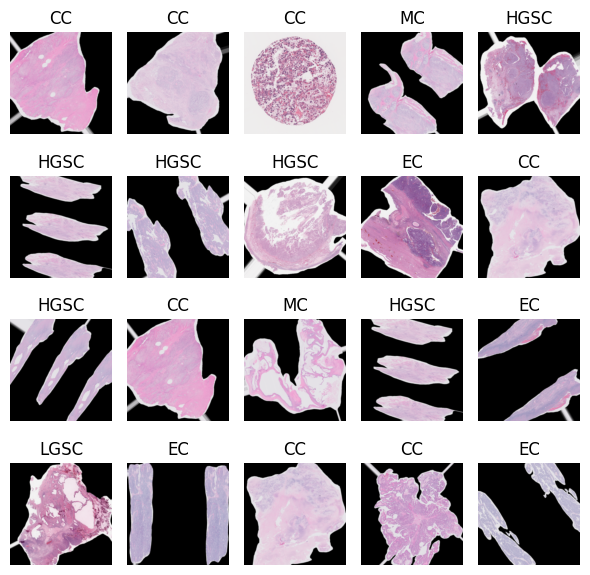

In [21]:
n_rows = 4
n_cols = 5

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6, 6))

for i in range(n_rows):
    for j in range(n_cols):
        r = random.randint(0, len(labels) - 1)

        axes[i, j].imshow(images[r])
        axes[i, j].set_title(classes[labels[r]])
        axes[i, j].axis('off') 

plt.tight_layout()
plt.show()

In [25]:
img_shape = img_size + tuple([3])

efficient_net = EfficientNetB5(
                    weights="imagenet",
                    input_shape=img_shape,
                    include_top=False,
                    pooling="max")

model = Sequential()
model.add(efficient_net)
model.add(layers.Dense(16,activation="relu"))
model.add(layers.Dense(len(classes),activation="softmax"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional  (None, 2048)              28513527  
 )                                                               
                                                                 
 dense_2 (Dense)             (None, 16)                32784     
                                                                 
 dense_3 (Dense)             (None, 5)                 85        
                                                                 
Total params: 28546396 (108.90 MB)
Trainable params: 28373653 (108.24 MB)
Non-trainable params: 172743 (674.78 KB)
_________________________________________________________________


In [26]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [27]:
model.fit(train_gen,
          steps_per_epoch = train_gen.samples // batch_size,
          validation_data = val_gen,
          validation_steps = val_gen.samples // batch_size,
          epochs=5)

Epoch 1/5


2023-12-05 00:21:42.701237: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/efficientnetb5/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


26/26 [==============================] - 219s 5s/step - loss: 2.0553 - accuracy: 0.3470 - val_loss: 1.5747 - val_accuracy: 0.3646
Epoch 2/5
26/26 [==============================] - 123s 5s/step - loss: 1.6071 - accuracy: 0.3928 - val_loss: 1.5959 - val_accuracy: 0.4271
Epoch 3/5
26/26 [==============================] - 123s 5s/step - loss: 1.5917 - accuracy: 0.4024 - val_loss: 1.5838 - val_accuracy: 0.4583
Epoch 4/5
26/26 [==============================] - 123s 5s/step - loss: 1.5919 - accuracy: 0.4048 - val_loss: 1.5795 - val_accuracy: 0.4583
Epoch 5/5
26/26 [==============================] - 123s 5s/step - loss: 1.5746 - accuracy: 0.4072 - val_loss: 1.5720 - val_accuracy: 0.4375


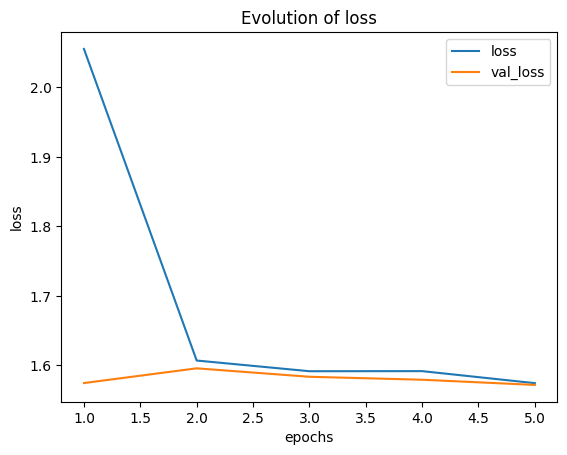

In [28]:
loss = model.history.history["loss"]
val_loss = model.history.history["val_loss"]
acc = model.history.history["accuracy"]
val_acc = model.history.history["val_accuracy"]
x = np.arange(1,len(loss)+1)

plt.plot(x,loss,label="loss")
plt.plot(x,val_loss,label="val_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.title("Evolution of loss")
plt.show()

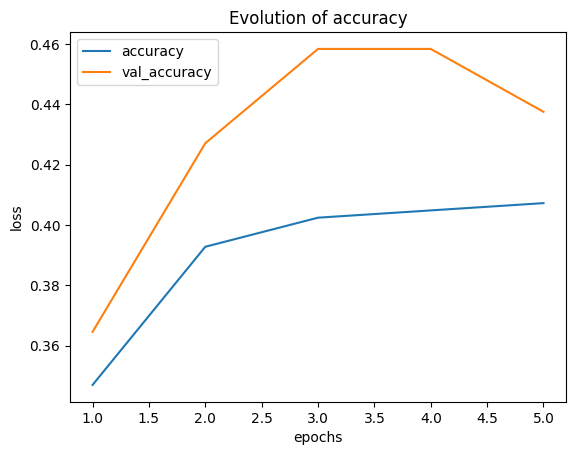

In [29]:
plt.plot(x,acc,label="accuracy")
plt.plot(x,val_acc,label="val_accuracy")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.title("Evolution of accuracy")
plt.show()

We now evaluate the model on the validation set

In [34]:
y_pred_raw = model.predict(val_gen)
y_pred = np.argmax(y_pred_raw, axis=1)

7/7 [==============================] - 21s 3s/step


In [36]:
model.evaluate(val_gen)

7/7 [==============================] - 22s 3s/step - loss: 1.5701 - accuracy: 0.4579


[1.57008957862854, 0.4579439163208008]

Let's visualise the confusion matrix

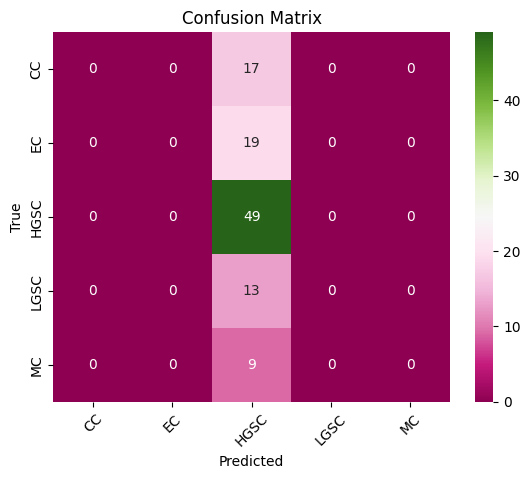

In [39]:
cm = confusion_matrix(val_gen.classes,y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="PiYG", xticklabels=classes, yticklabels=classes)

# Add labels and title
plt.xlabel('Predicted')
plt.xticks(rotation=45)
plt.ylabel('True')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

Due to the highly imbalanced data, the model only predicts one category.